# Problématique

<h3> Prédire le nombre de lettres dans l'image (régression)</h3>

- Sample de 1000 observations (1000 mots) : charger (function preprocess (utiliser en sortie un .numpy() pour avoir des arrays), container toutes observations pour faire une matrice de taille (nb_observation, nb_features).
- Modèle Deep learning : MLP
- Évaluation du modèle : MAE métrique


# Import

In [40]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import re
from os.path import exists

In [68]:
import letter_detection_utils as ld_util
from importlib import reload 
import warnings

# Ensure we have always the latest state and 
# not the last import in memory
reload(ld_util)

<module 'letter_detection_utils' from '/Users/jpec/Prog/OCRpyMAN/notebooks/letter_detection_utils.py'>

# Chargement du dataframe

In [64]:
img_size = (32, 128)
data = ld_util.get_dataframe_with_preprocessed_imgs(img_size=img_size)

df = data['df']
preprocessed_imgs = data['preprocessed_imgs']

Loading existing data from  ../pickle/letter_detection_data.pickle ...


In [62]:
print("Length: ", len(df))
print("Imgs length: ", len(preprocessed_imgs))
print("Img shape: ", preprocessed_imgs[0].shape)

Length:  1000
Imgs length:  1000
Img shape:  (4096,)


In [44]:
df.head(3)

,index,michelson_contrast,gray_level_mot,word_id,gray_level,x,y,w,h,transcription,word_img_path,form_img_path,length
0,944,0.758621,0.889522,a01-020u-06-05,170,1954,1831,389,100,studying,../data/words/a01/a01-020u/a01-020u-06-05.png,../data/formsA-D/a01-020u.png,8
1,914,0.695946,0.774799,a01-020u-02-06,169,1565,1129,128,49,has,../data/words/a01/a01-020u/a01-020u-02-06.png,../data/formsA-D/a01-020u.png,3
2,581,0.683168,0.830613,a01-011u-04-05,166,1622,1472,321,62,discuss,../data/words/a01/a01-011u/a01-011u-04-05.png,../data/formsA-D/a01-011u.png,7


# Data visualisation

Pour travailler avec les images et comparer le ratio hauteur/largeur, il faut au préalable rescale nos images.

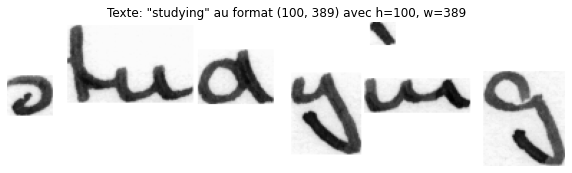

In [72]:
ld_util.show_df_word_img(df, 0)

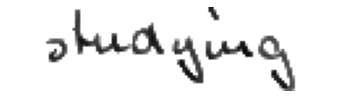

In [66]:
ld_util.show_preprocess_img_from_data(data, 0)

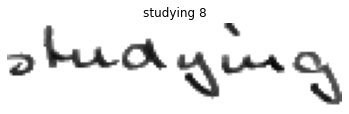

In [69]:
ld_util.show_preprocess_img_from_df(df, 0)

In [46]:
# ld_util.show_df_form_img(df, 0)

In [47]:
df[['transcription', 'length', 'w', 'word_img_path', 'form_img_path']].sort_values(by=['w']).iloc[-3:]

,transcription,length,w,word_img_path,form_img_path
79,Independence,12,586,../data/words/a01/a01-011u/a01-011u-01-02.png,../data/formsA-D/a01-011u.png
627,Protectorate's,14,605,../data/words/a01/a01-014x/a01-014x-01-05.png,../data/formsA-D/a01-014x.png
15,demonstrations,14,640,../data/words/a01/a01-014x/a01-014x-06-02.png,../data/formsA-D/a01-014x.png


In [48]:
df[['transcription', 'length', 'w', 'word_img_path', 'form_img_path']].sort_values(by=['w']).iloc[:3]

,transcription,length,w,word_img_path,form_img_path
148,A,1,27,../data/words/a01/a01-000u/a01-000u-00-00.png,../data/formsA-D/a01-000u.png
673,is,2,30,../data/words/a01/a01-000x/a01-000x-01-05.png,../data/formsA-D/a01-000x.png
441,a,1,32,../data/words/a01/a01-000x/a01-000x-01-10.png,../data/formsA-D/a01-000x.png


Hypothèse: le nombre de caractère est proportionnel à la largeur des boîtes.

In [49]:
df['length'].describe()

count    1000.00000
mean        4.84800
std         2.48658
min         1.00000
25%         3.00000
50%         4.00000
75%         7.00000
max        15.00000
Name: length, dtype: float64

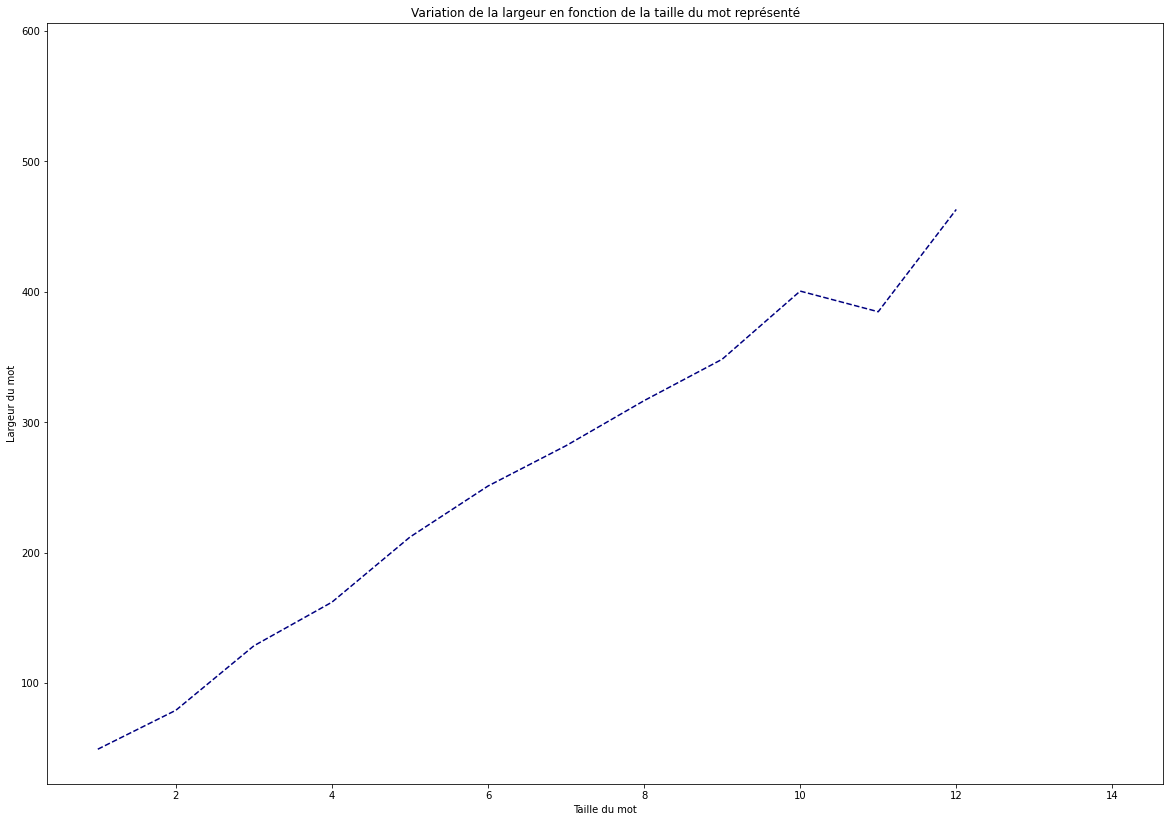

In [50]:
ld_util.plot_avg_width_per_string_length(df)

# Model

In [70]:
from sklearn.model_selection import train_test_split


target = df['length'].to_numpy()
# We do not shuffle to have X_train[index] to match df[index]
X_train, X_test, y_train, y_test = train_test_split(preprocessed_imgs, target, test_size=0.2, shuffle=False)

## Manual MLP

In [52]:
# from tensorflow.keras.layers import Input, Dense
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dropout 
# from tensorflow.keras.layers import Flatten
# from tensorflow.keras.layers import Conv2D 
# from tensorflow.keras.layers import MaxPooling2D
# from keras.utils import to_categorical



# inputs = Input(shape=(X_train.shape[1]))
# first_layer = Dense(180, activation='tanh', kernel_initializer='random_normal', name='Dense_1')
# second_layer = Dense(256, activation='tanh', kernel_initializer='random_normal', name='Dense_2')
# third_layer = Dense(1, activation='softmax', name='Dense_3')

# outputs=first_layer(inputs)
# outputs=second_layer(outputs)
# outputs=third_layer(outputs)
# model = Model(inputs = inputs, outputs = outputs)


In [53]:
# model.summary()


In [54]:
# import tensorflow as tf

# model.compile(loss=tf.keras.losses.MeanAbsoluteError(), metrics=['accuracy'], optimizer='adam')
# training_history = model.fit(X_train, y_train, batch_size=50, epochs=20)


In [55]:
# training_history.history['loss']

## MLP

### Without Grid Search

In [56]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    solver='lbfgs', 
    activation='relu',
    alpha=1e-4, 
    hidden_layer_sizes=(64, 256, 1024), 
    max_iter=10_000,
    random_state=42
)
# {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (64, 256, 1024)}
mlp.fit(X_train, y_train)

print(mlp.score(X_test, y_test))
y_pred = mlp.predict(X_test)
y_pred_proba = mlp.predict_proba(X_test)

0.185


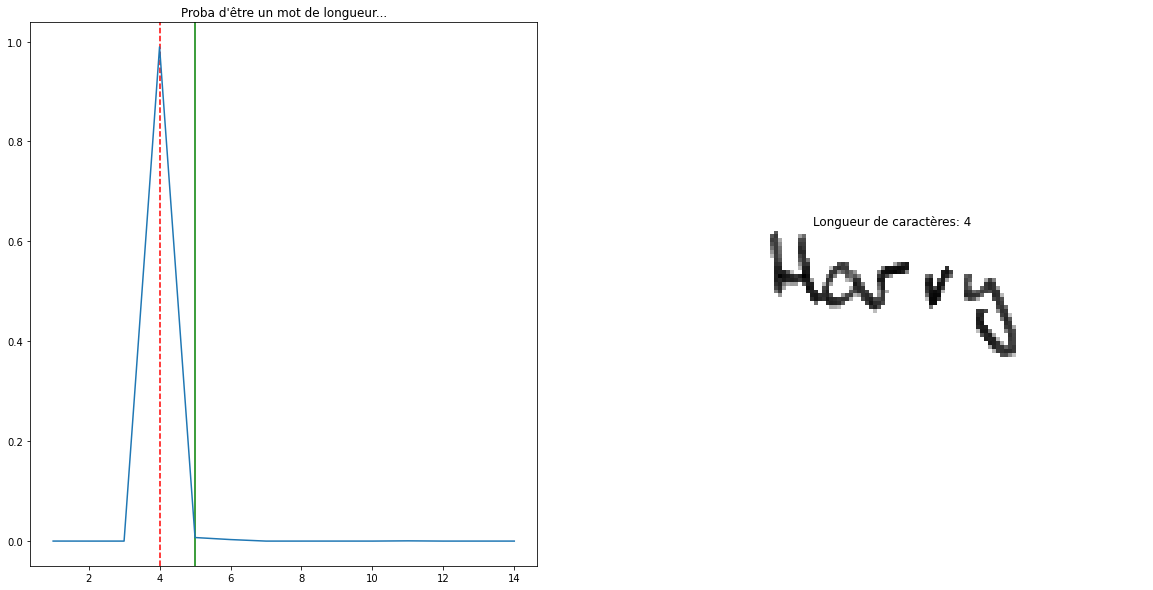

In [57]:
ld_util.show_mlp_result_for_row(X_test, y_test, y_pred, y_pred_proba, 0)

### Regressor

In [58]:
from sklearn.neural_network import MLPRegressor

mlp_reg = MLPRegressor(
    solver='lbfgs', 
    activation='relu',
    alpha=1e-4, 
    hidden_layer_sizes=(64, 256, 1024), 
    max_iter=10_000,
    random_state=42
)
# {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (64, 256, 1024)}
mlp_reg.fit(X_train, y_train)

print(mlp_reg.score(X_test, y_test))
y_pred = mlp_reg.predict(X_test)
# y_pred_proba = mlp.predict_proba(X_test)


KeyboardInterrupt: 

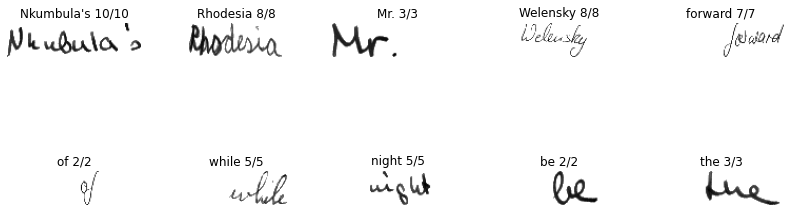

In [71]:
plt.figure(figsize=(14, 5))
j = 1
for i in np.random.randint(low=0, high=len(X_train), size=[10]):
    plt.subplot(2, 5, j)
    plt.axis('off')
    plt.imshow(X_train[i].reshape(img_size), cmap='gray');
    plt.title(df.iloc[i].transcription + ' ' + str(df.iloc[i].length) + '/' + str(y_train[i]))
    j+=1

### With GridSearch

- Solver: "lbfgs"
    Note: The default solver ‘adam’ works pretty well on relatively large datasets (with thousands of training samples or more) in terms of both training time and validation score. For small datasets, however, ‘lbfgs’ can converge faster and perform better.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier


mlp = MLPClassifier(solver='lbfgs', random_state=42, max_iter=1_000)

params = {
    'activation' : ['logistic', 'tanh', 'relu'],
    'alpha': [1e-5, 1e-4, 1e-3],
    'hidden_layer_sizes': [(2**6, 2**8), (2**6, 2**8, 2**10)],
    # 'max_iter': [200, 500, 1_000]
}

grid_search = GridSearchCV(mlp, params)
grid_search.fit(X_train, y_train)

print('best params', grid_search.best_params_)
print(grid_search.score(X_test, y_test))

y_pred = grid_search.predict(X_test)
y_pred_proba = grid_search.predict_proba(X_test)

/Users/jpec/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,
/Users/jpec/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/jpec/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


best params {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (64, 256, 1024)}
0.265


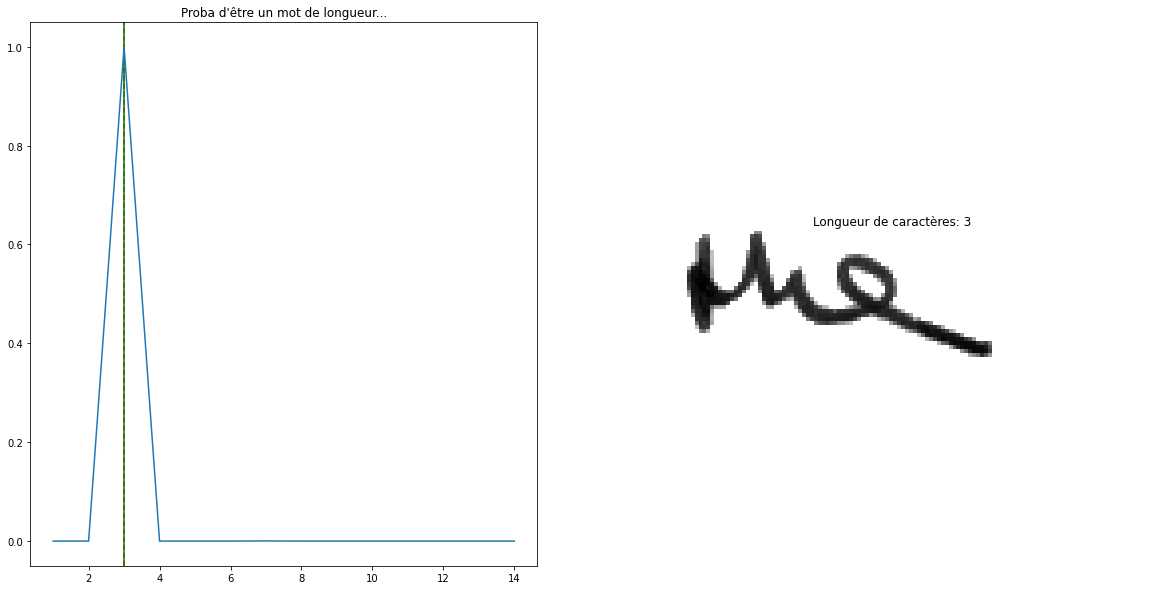

In [ ]:
ld_util.show_mlp_result_for_row(X_test, y_test, y_pred, y_pred_proba, 0)

## Linear

In [ ]:
from sklearn.linear_model import LinearRegression


X_lin_train, X_lin_test, y_lin_train, y_lin_test = train_test_split(df[['w', 'h']], df['length'], test_size=0.2)

lr = LinearRegression()
lr.fit(X_lin_train, y_lin_train)
score = lr.score(X_lin_test, y_lin_test)
y_lin_test_pred = lr.predict(X_lin_test)

print("Score: ", score)

Score:  0.8618015699384322


In [ ]:
for i in range(10):
    pred = round(y_lin_test_pred[i])
    real = y_lin_test.iloc[i] 
    print('predicted: ',pred , 'real:', real)

predicted:  5 real: 4
predicted:  7 real: 8
predicted:  5 real: 5
predicted:  7 real: 7
predicted:  3 real: 3
predicted:  10 real: 11
predicted:  2 real: 2
predicted:  3 real: 3
predicted:  7 real: 8
predicted:  3 real: 3


# TODOs

- Add rotation to letters to data gen
